# NAM KIM GROUP


In [154]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [155]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('NKG Historical Data.csv')
df1=df.reset_index()['Price']

In [156]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,Unnamed: 7
0,3/1/2024,24.15,24.00,24.20,23.80,5.94M,0,84%
1,2/29/2024,23.95,24.25,24.25,23.80,8.67M,0,83%
2,2/28/2024,24.15,24.10,24.30,23.90,6.53M,0,21%
3,2/27/2024,24.10,23.85,24.55,23.80,11.22M,1,69%
4,2/26/2024,23.70,23.35,23.85,23.25,7.55M,1,7%


In [157]:
df1.head()

0    24.15
1    23.95
2    24.15
3    24.10
4    23.70
Name: Price, dtype: float64

In [158]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [159]:
# 4. Chia train test
train_size = int(0.65 * len(df1))
test_size = int(0.25 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [160]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [161]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [162]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [163]:
# 8. Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [164]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 2s 46ms/step - loss: 0.0234 - val_loss: 4.6568e-04
Epoch 2/100
12/12 [==============================] - 0s 23ms/step - loss: 0.0065 - val_loss: 0.0019
Epoch 3/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0024 - val_loss: 9.8888e-04
Epoch 4/100
12/12 [==============================] - 0s 23ms/step - loss: 0.0016 - val_loss: 3.3934e-04
Epoch 5/100
12/12 [==============================] - 0s 23ms/step - loss: 0.0012 - val_loss: 4.3581e-04
Epoch 6/100
12/12 [==============================] - 0s 24ms/step - loss: 9.4929e-04 - val_loss: 5.5618e-04
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 8.8800e-04 - val_loss: 5.1030e-04
Epoch 8/100
12/12 [==============================] - 0s 22ms/step - loss: 8.3937e-04 - val_loss: 3.4666e-04
Epoch 9/100
12/12 [==============================] - 0s 23ms/step - loss: 7.9799e-04 - val_loss: 3.4800e-04
Epoch 10/100
12/12 [==============================] 

In [165]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 37ms/step


In [166]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [167]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [168]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.3866643645150356
Testing RMSE: 0.3712956938091481


In [170]:
# Đánh giá độ chính xác thuật toán bằng MAE
valid_mae = np.mean(abs(y_pred_val - yval))
test_mae = np.mean(abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 0.3634478591918946
Testing MAE: 0.32758063158898987


In [171]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))

print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 0.06914620701622037
Testing MAPE: 0.06873881638849787


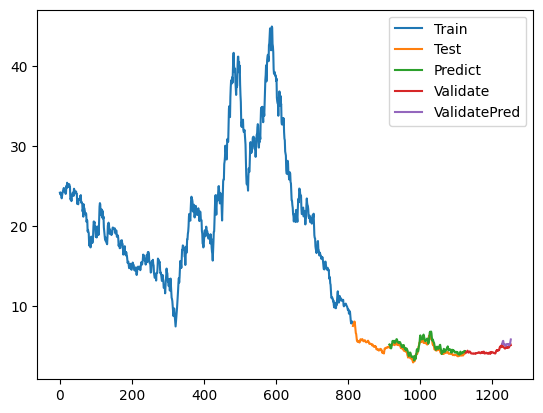

In [172]:
# 14.Vẽ hình
# Train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
# Test
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
# Dự đoán trên tập test
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
# Validate
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
# Dự đoán trên tập validated
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()